# Modelado de Concentrados Minerales de la Empresa Zyfra

Este proyecto tiene como objetivo modela la producción de concentrados minerales de una mina con un proceso metalúrgico simplificado, especificamente el de una mina de oro. Cabe destacar que el trabajo principal es separar y concentrar los minerales valiosos de aquellos que no se consideran así o se definen como estériles, teniendo como un conjunto de procesos los cuales encontramos a: la trituración, la molienda, la flotación, la separación magnética, la lixiviación y el espesamiento y filtración.


# Tabla de contenido

* [1 Preparación de los datos](#1)
    * [1.1 Abrir los archivos y examinar los datos](#1.1)
    * [1.2 Verificar el cálculo de la recuperación de la característica "rougher.output.recovery" utilizando el conjunto de entrenamiento](#1.2)
    * [1.3 Analizar las características que no están disponibles en el conjunto de prueba ](#1.3)
    * [1.4 Realizar el preprocesamiento de datos](#1.4)
        * [1.4.1 Rellenar los valores ausentes](#1.4.1)
        * [1.4.2 Arreglar el tipo de columna 'date'](#1.4.2)
* [2 Análisis de los datos](#2)
    * [2.1 Observar cómo cambia la concentración de los metales (Au, Ag, Pb) en función de la etapa de purificación](#2.1)
    * [2.2 Comparar las distribuciones del tamaño de las partículas de la alimentación entre el conjunto de entrenamiento y el conjunto de prueba ](#2.2)
    * [2.3 Considerar las concentraciones totales de todas las sustancias en las diferentes etapas](#2.3)
        * [Materia prima](#2.3.1)
        * [Concentrado Rougher](#2.3.2)
        * [Concentrado Final](#2.3.3)
    * [2.4 Eliminar anomalías](#2.4)    
* [3 Desarrollo del modelo](#3)
    * [3.1 Escribir una función para calcular el valor final de sMAPE](#3.1)
    * [3.2 Entrenar diferentes modelos y evaluarlos utilizando validación cruzada](#3.2)
        * [3.2.1 Definir la función para aplicar a los modelos](#3.2.1)
        * [3.2.2 Regresión lineal](#3.2.2)
        * [3.2.3 Árbol de decisión](#3.2.3)
        * [3.2.4 Bosque aleatorio](#3.2.4)
    * [3.3 Seleccionar el mejor modelo y probarlo utilizando el conjunto de prueba](#3.3)
* [4 Conclusiones generales](#4)   




## Preparación de los Datos

### Abrir los archivos y examinar los datos

In [9]:
# importamos las librerías

!pip install sidetable

In [10]:
# importamos las librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable as stb
import warnings 
warnings.filterwarnings('ignore')

from collections import defaultdict

from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
# cargamos los Dataframes

gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [12]:
# mostramos información general del Dataframe 'gold_train'

gold_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [13]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [14]:
gold_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [15]:
# mostramos información general del Dataframe 'gold_test'

gold_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [16]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [17]:
gold_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [18]:
# mostramos información general del Dataframe 'gold_full'

gold_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [19]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [20]:
gold_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [21]:
# determinamos si en cada Dataframe existen valores ausentes

gold_train.stb.missing()

,missing,total,percent
rougher.output.recovery,2573,16860,15.260973
rougher.output.tail_ag,2250,16860,13.345196
rougher.output.tail_sol,2249,16860,13.339265
rougher.output.tail_au,2249,16860,13.339265
secondary_cleaner.output.tail_sol,1986,16860,11.779359
...,...,...,...
primary_cleaner.state.floatbank8_d_level,27,16860,0.160142
rougher.calculation.floatbank10_sulfate_to_au_feed,27,16860,0.160142
rougher.calculation.floatbank11_sulfate_to_au_feed,27,16860,0.160142
primary_cleaner.input.feed_size,0,16860,0.000000


In [22]:
gold_test.stb.missing()

,missing,total,percent
rougher.input.floatbank11_xanthate,353,5856,6.028005
primary_cleaner.input.sulfate,302,5856,5.157104
primary_cleaner.input.depressant,284,5856,4.849727
rougher.input.floatbank10_sulfate,257,5856,4.388661
primary_cleaner.input.xanthate,166,5856,2.834699
rougher.input.floatbank10_xanthate,123,5856,2.100410
rougher.input.feed_sol,67,5856,1.144126
rougher.input.floatbank11_sulfate,55,5856,0.939208
rougher.input.feed_rate,40,5856,0.683060
secondary_cleaner.state.floatbank3_a_air,34,5856,0.580601


In [23]:
gold_full.stb.missing()

,missing,total,percent
rougher.output.recovery,3119,22716,13.730410
rougher.output.tail_ag,2737,22716,12.048776
rougher.output.tail_au,2736,22716,12.044374
rougher.output.tail_sol,2736,22716,12.044374
rougher.input.floatbank11_xanthate,2257,22716,9.935728
...,...,...,...
primary_cleaner.state.floatbank8_b_level,43,22716,0.189294
primary_cleaner.state.floatbank8_c_level,43,22716,0.189294
primary_cleaner.state.floatbank8_d_level,43,22716,0.189294
primary_cleaner.input.feed_size,0,22716,0.000000


**Resumen:**

* Tenemos 3 datasets, donde en golden_train y golden_full aparece una columna en común: 'rougher.output.recovery' con valores ausentes, se procederá a rellenarlos con la clase KNNImputer.

* Posteriormente, dentro del apartado de Preparación de los datos, definiremos las variables y la fórmulña para el cálculo de la recuperación.

* Realizaremos análisis, como las características que no están en el conjunto de prueba, así como determinar si no hay valores ausentes en los datasets y que los tipos de las columnas esten correctos.

### Verificar el cálculo de la recuperación de la característica "rougher.output.recovery" utilizando el conjunto de entrenamiento

In [24]:
# definimos las varibales y la fórmula

C = gold_train['rougher.output.concentrate_au']
F = gold_train['rougher.input.feed_au']
T = gold_train['rougher.output.tail_au']

recovery = (C * (F - T)) / (F * (C - T)) * 100

rougher_output_recovery =  gold_train['rougher.output.recovery'].dropna()
recovery = recovery.iloc[rougher_output_recovery.index]

print('MAE:', mean_absolute_error(rougher_output_recovery, recovery))

MAE: 9.303415616264301e-15


Podemos observar que el Error Promedio Absoluto está muy cerca de 0, lo cual nos da a entender que con el conjunto de datos de entrenamiento se hara un modelado de regreción con un ajuste muy preciso, lo que nos lleva a que los procesos que se realizarán a continuación estén muy cercanos a los valores reales, pero de igual manera habrá que evaluar el modelo para estar más seguros, donde se nos dice por ejemplo que hay que realizar una validación cruzada.


### Analizar las características que no están disponibles en el conjunto de prueba 

In [25]:
# buscamos las columnas que no están en gold_test

column_not = gold_train.columns.difference(gold_test.columns)
list(column_not)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [26]:
# contamos las columnas que no están en gold_test

print('TOTAL DE COLUMNAS FALTANTES:', len(column_not))
print()
print('PORCENTAJE DE COLUMNAS FALTANTES:', (len(column_not) / len(gold_train.columns)) * 100)

TOTAL DE COLUMNAS FALTANTES: 34

PORCENTAJE DE COLUMNAS FALTANTES: 39.08045977011494


### Realizar el preprocesamiento de los datos.

#### Rellenamos los valores ausentes

In [27]:
# observamos al Dataframe 'gold_train' con valores ausentes

gold_train[gold_train.isna().any(axis = 1)].head()


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,NaN,43.389252,NaN,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218
50,2016-01-17 02:00:00,8.162896,8.877528,NaN,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,13.984906,-550.563329,11.999730,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929
53,2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399


In [28]:
# creamos una función para rellenar los valores ausentes

def rellenar_ausentes(dataset):
    df_date = pd.DataFrame(dataset.copy().loc[:, 'date'])
    drop_date = dataset.copy().drop(['date'], axis = 1) 
    
    knn_imputer = KNNImputer(n_neighbors = 3)
    knn_imputer.fit(drop_date)
    data_trans = knn_imputer.transform(drop_date)
    
    data_new = pd.DataFrame(data_trans, columns = dataset.columns.drop(['date']))
    data_new.insert(0, 'date', df_date.loc[:, 'date'])
    
    return data_new


In [29]:
# aplicamos la función a los Dataframes que ya tenemos

data_train = rellenar_ausentes(gold_train)
data_train.loc[48]


date                                          2016-01-17 00:00:00
final.output.concentrate_ag                               5.29683
final.output.concentrate_pb                             10.597469
final.output.concentrate_sol                             9.301367
final.output.concentrate_au                             44.015642
                                                     ...         
secondary_cleaner.state.floatbank5_a_level            -499.607365
secondary_cleaner.state.floatbank5_b_air                 7.958252
secondary_cleaner.state.floatbank5_b_level             -498.88256
secondary_cleaner.state.floatbank6_a_air                11.967977
secondary_cleaner.state.floatbank6_a_level            -599.440603
Name: 48, Length: 87, dtype: object

In [30]:
data_test = rellenar_ausentes(gold_test)
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [31]:
data_full = rellenar_ausentes(gold_full)
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [32]:
# revisamos si aun existen valores ausentes

print('VALORES AUSENTES EN data_train:', data_train.isna().sum().sum())
print()
print('VALORES AUSENTES EN data_test:', data_train.isna().sum().sum())
print()
print('VALORES AUSENTES EN data_test:', data_train.isna().sum().sum())

VALORES AUSENTES EN data_train: 0

VALORES AUSENTES EN data_test: 0

VALORES AUSENTES EN data_test: 0


#### Arreglamos el tipo de la columna 'Date'

In [33]:
#

datasets = [data_train, data_test, data_full]

for df in datasets:
    df['date'] = pd.to_datetime(df.loc[:, 'date'], format = '%Y-%m-%dT%H:%M:%S')

In [34]:
# comprobamos que las columnas tienen nuevo tipo

for df in datasets:
    print(df.loc[:, 'date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


**Conclusiones de la sección 1:**

* Nos encontramos con 3 dataframes, las cuales al momento de examinarlos poseían valores ausentes.

* En los dataframes de golden_train y golden_full, la columna 'rougher.output.recovery' mostraban valores ausentes del 15% y 13% respectivamente.

* Utilizamos la clase KNNImputer para estimar los valores ausentes.

* Se modifico la columna 'date' a tipo fecha.

* Se estableció la fórmula para calcular la recuperación de la característica "rougher.output.recovery" utilizando el conjunto de entrenamiento.

## Análisis de los Datos

### Observar cómo cambia la concentración de los metales (Au, Ag, Pb) en función de la etapa de purificación

In [35]:
# seleccionamos las columnas que contienen rougher.input.feed y concentrate_au

data_au = data_full.loc[:, data_full.columns.str.contains('rougher.input.feed_au|concentrate_au')]
display(data_au)

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.input.feed_au,rougher.output.concentrate_au
0,42.192020,34.174427,6.486150,19.793808
1,42.701629,34.118526,6.478583,20.050975
2,42.657501,33.969464,6.362222,19.737170
3,42.689819,28.260743,6.118189,19.320810
4,42.774141,33.044932,5.663707,19.216101
...,...,...,...,...
22711,46.713954,32.940215,5.335862,18.603550
22712,46.866780,32.925325,4.838619,18.441436
22713,46.795691,31.856742,4.525061,15.111231
22714,46.408188,30.770892,4.362781,17.834772


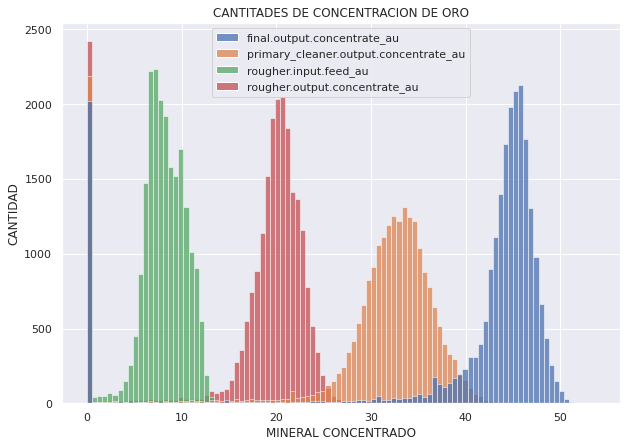

In [36]:
# graficamos

sns.set()

plt.figure(figsize =(10, 7))
sns.histplot(data_au, bins = 100)
plt.xlabel('MINERAL CONCENTRADO')
plt.ylabel('CANTIDAD')
plt.title('CANTITADES DE CONCENTRACION DE ORO')
plt.show()

In [37]:
data_plata = data_full.loc[:, data_full.columns.str.contains('rougher.input.feed_au|concentrate_ag')]
display(data_plata)

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.input.feed_au,rougher.output.concentrate_ag
0,6.055403,8.547551,6.486150,11.500771
1,6.029369,8.558743,6.478583,11.615865
2,6.055926,8.603505,6.362222,11.695753
3,6.047977,7.221879,6.118189,11.915047
4,6.148599,9.089428,5.663707,12.411054
...,...,...,...,...
22711,3.224920,6.559174,5.335862,11.124896
22712,3.195978,6.612376,4.838619,11.425983
22713,3.109998,7.128896,4.525061,8.523497
22714,3.367241,7.490444,4.362781,11.658799


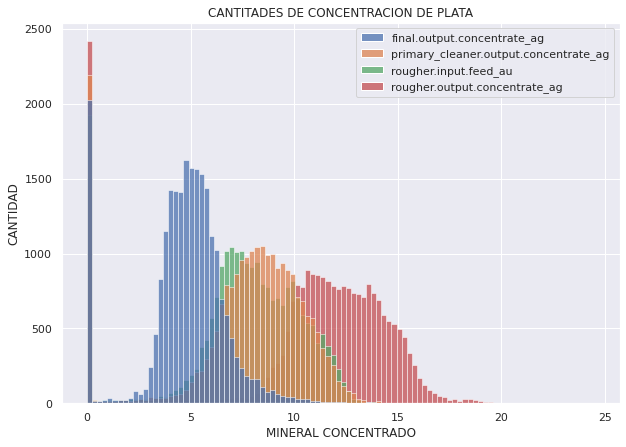

In [38]:
sns.set()

plt.figure(figsize =(10, 7))
sns.histplot(data_plata, bins = 100)
plt.xlabel('MINERAL CONCENTRADO')
plt.ylabel('CANTIDAD')
plt.title('CANTITADES DE CONCENTRACION DE PLATA')
plt.show()

In [39]:
data_plomo = data_full.loc[:, data_full.columns.str.contains('rougher.input.feed_au|concentrate_pb')]
display(data_plomo)

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.input.feed_au,rougher.output.concentrate_pb
0,9.889648,10.389648,6.486150,7.101074
1,9.968944,10.497069,6.478583,7.278807
2,10.213995,10.354494,6.362222,7.216833
3,9.977019,8.496563,6.118189,7.175616
4,10.142511,9.986786,5.663707,7.240205
...,...,...,...,...
22711,11.356233,12.445966,5.335862,10.984003
22712,11.349355,12.623947,4.838619,10.888213
22713,11.434366,12.633558,4.525061,8.955135
22714,11.625587,12.012378,4.362781,10.655377


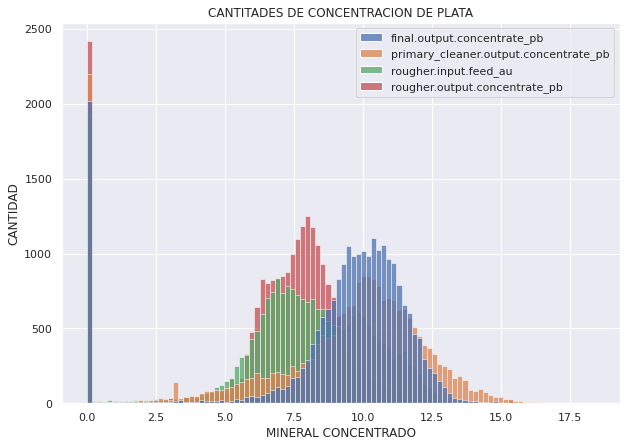

In [40]:
sns.set()

plt.figure(figsize =(10, 7))
sns.histplot(data_plomo, bins = 100)
plt.xlabel('MINERAL CONCENTRADO')
plt.ylabel('CANTIDAD')
plt.title('CANTITADES DE CONCENTRACION DE PLATA')
plt.show()

### Comparar las distribuciones del tamaño de las partículas de la alimentación entre el conjunto de entrenamiento y el conjunto de prueba

In [41]:
# filtramos la data

train_feed = data_train.loc[:, 'rougher.input.feed_size']
test_feed = data_test.loc[:, 'rougher.input.feed_size']

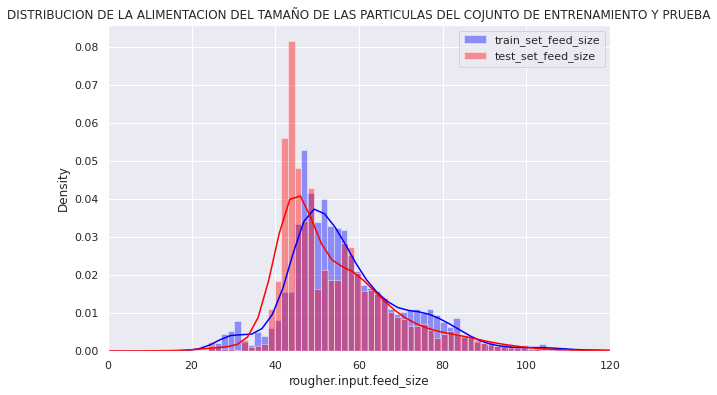

In [42]:
# realizamos el gráfico del tamaño de la alimentación

plt.figure(figsize = (9, 6))
plt.xlim(0, 120)
plt.title('DISTRIBUCION DE LA ALIMENTACION DEL TAMAÑO DE LAS PARTICULAS DEL COJUNTO DE ENTRENAMIENTO Y PRUEBA')
sns.distplot(train_feed, bins = 300, color = 'blue', label = 'train_set_feed_size')
sns.distplot(test_feed, bins = 300, color = 'red', label = 'test_set_feed_size')
plt.legend()
plt.show()

### Considerar las concentraciones totales de todas las sustancias en las diferentes etapas:

#### Materia Prima

In [43]:
# seleccionamos las columnas que tengan concentrado de oro

rougher_input = data_full.loc[:, ((~data_full.columns.str.contains('_size|_rate')) & (data_full.columns.str.contains('rougher.input.feed_')))]
rougher_input['total'] = rougher_input.copy().sum(axis = 1)
display(rougher_input)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,total
0,6.100378,2.284912,36.808594,6.486150,51.680034
1,6.161113,2.266033,35.753385,6.478583,50.659114
2,6.116455,2.159622,35.971630,6.362222,50.609929
3,6.043309,2.037807,36.862241,6.118189,51.061546
4,6.060915,1.786875,34.347666,5.663707,47.859163
...,...,...,...,...,...
22711,6.091855,4.617558,37.369774,5.335862,53.415050
22712,6.121323,4.144989,38.591551,4.838619,53.696482
22713,5.970515,4.020002,40.074026,4.525061,54.589604
22714,6.048130,3.902537,39.713906,4.362781,54.027355


<function matplotlib.pyplot.show(close=None, block=None)>

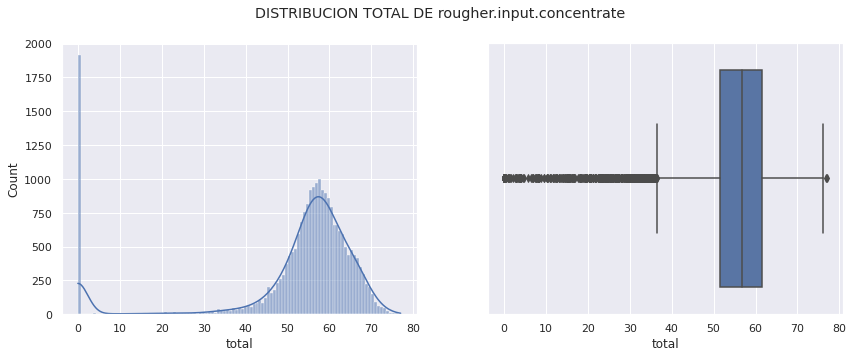

In [44]:
# creamos el gráfico de la distribución rougher.input.concentrate

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.histplot(data = rougher_input, x = rougher_input['total'], kde = True, ax = axes[0])
sns.boxplot(data = rougher_input, x = rougher_input['total'], ax = axes[1])

fig.suptitle('DISTRIBUCION TOTAL DE rougher.input.concentrate')
plt.show

#### Concentrado Rougher 

In [45]:
# seleccionamos las columnas que tengan concentrado de plata

rougher_concentrado = data_full.loc[:, ((~data_full.columns.str.contains('_size|_rate')) & (data_full.columns.str.contains('rougher.output.concentrate_')))]
rougher_concentrado['total'] = rougher_concentrado.copy().sum(axis = 1)
display(rougher_concentrado)

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,total
0,11.500771,7.101074,28.029297,19.793808,66.424950
1,11.615865,7.278807,28.067063,20.050975,67.012710
2,11.695753,7.216833,27.454037,19.737170,66.103793
3,11.915047,7.175616,27.341277,19.320810,65.752751
4,12.411054,7.240205,27.041023,19.216101,65.908382
...,...,...,...,...,...
22711,11.124896,10.984003,30.068876,18.603550,70.781325
22712,11.425983,10.888213,29.783972,18.441436,70.539603
22713,8.523497,8.955135,22.786467,15.111231,55.376330
22714,11.658799,10.655377,29.052742,17.834772,69.201689


<function matplotlib.pyplot.show(close=None, block=None)>

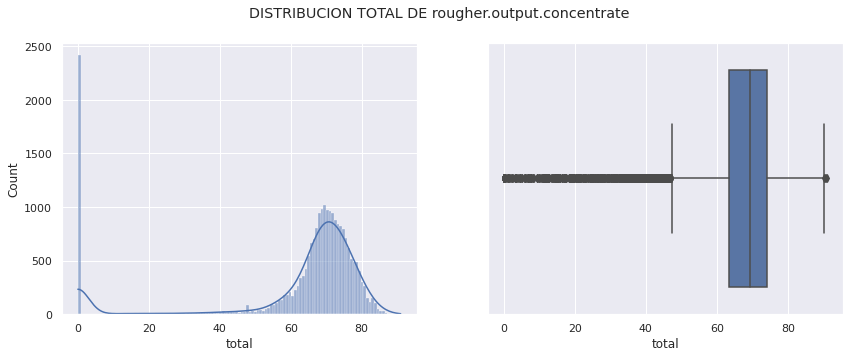

In [46]:
# creamos el gráfico de la distribución rougher.output.concentrate

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.histplot(data = rougher_concentrado, x = rougher_concentrado['total'], kde = True, ax = axes[0])
sns.boxplot(data = rougher_concentrado, x = rougher_concentrado['total'], ax = axes[1])

fig.suptitle('DISTRIBUCION TOTAL DE rougher.output.concentrate')
plt.show

#### Concentrado Final

In [47]:
# seleccionamos las columnas que tengan concentrado de plomo

rougher_final = data_full.loc[:, ((~data_full.columns.str.contains('_size|_rate')) & (data_full.columns.str.contains('final.output.concentrate_')))]
rougher_final['total'] = rougher_final.copy().sum(axis = 1)
display(rougher_final)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,total
0,6.055403,9.889648,5.507324,42.192020,63.644396
1,6.029369,9.968944,5.257781,42.701629,63.957723
2,6.055926,10.213995,5.383759,42.657501,64.311180
3,6.047977,9.977019,4.858634,42.689819,63.573449
4,6.148599,10.142511,4.939416,42.774141,64.004667
...,...,...,...,...,...
22711,3.224920,11.356233,6.803482,46.713954,68.098589
22712,3.195978,11.349355,6.862249,46.866780,68.274362
22713,3.109998,11.434366,6.886013,46.795691,68.226068
22714,3.367241,11.625587,6.799433,46.408188,68.200449


<function matplotlib.pyplot.show(close=None, block=None)>

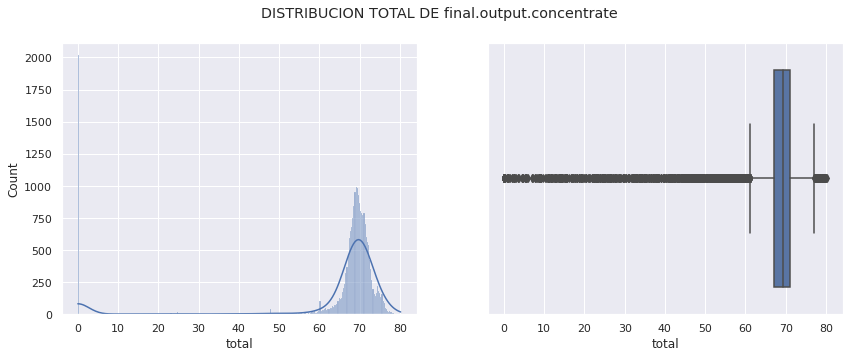

In [48]:
# creamos el gráfico de la distribución rougher.output.concentrate

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.histplot(data = rougher_final, x = rougher_final['total'], kde = True, ax = axes[0])
sns.boxplot(data = rougher_final, x = rougher_final['total'], ax = axes[1])

fig.suptitle('DISTRIBUCION TOTAL DE final.output.concentrate')
plt.show

### Eliminar anomalías

In [49]:
# observamos el tamaño de los dataset

print(data_full.shape)
print(data_train.shape)
print(data_test.shape)

(22716, 87)
(16860, 87)
(5856, 53)


In [50]:
materia_prima = list(rougher_input.drop(['total'], axis = 1))
concentrado_out = list(rougher_concentrado.drop(['total'], axis = 1))
concentrado_final = list(rougher_final.drop(['total'], axis = 1))

all_concentrate = []

for out in [materia_prima, concentrado_out, concentrado_final]:
    all_concentrate.extend(out)
    
all_concentrate


['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au']

In [51]:
# eliminamos las anomalías

data_train = data_train.loc[(data_train[all_concentrate] != 0).all(axis = 1)].reset_index(drop = True)

data_full_test = data_full.loc[data_test.index]
data_test = data_test.loc[(data_full_test[all_concentrate] != 0).all(axis = 1)].reset_index(drop = True)

data_full = data_full.loc[(data_full[all_concentrate] != 0).all(axis = 1)].reset_index(drop = True)


In [52]:
# mostramos el tamaño de los dataset

print(data_full.shape)
print(data_train.shape)
print(data_test.shape)

(20461, 87)
(15174, 87)
(5216, 53)


**Conclusiones de la sección 2:**

* Se observaron diferentes distribuciones en las concentraciones de los metales solicitados: oro, plata y plomo.

* En el oro, la concentración aumentó significativamente en cada proceso de extracción. En la plata, el aumento ocurre en las primeras etapas pero va disminuyendo hasta los procesos finales y en el plomo, no hay disminución de la concentración y al final del proceso, la concentración es la misma que al final.

* Se pudo ver que hay muchos concentrados que tienen un valor de 0. Se supone que si la materia prima en el primer proceso se pone es igual a 0, dará como consecuencia que el siguiente proceso no tendrá valor, lo cual nos lleva a la conclusión que no hay materia prima o concentrado.

* Se procedió a eliminar los valores de las columnas del conjunto de prueba y entrenamiento.


## Desarrollo del Modelo

### Escribir una función para calcular el valor final de sMAPE

In [53]:
# creamos la funcion sMAPE

def smape(actual, pronostico):
    result = (np.mean(abs(actual - pronostico) / ((abs(actual) + abs(pronostico)) / 2))) * 100
    final_smape = 0.25 * result[0] + 0.75 * result[1]
    return final_smape

smape_score = make_scorer(smape, greater_is_better = False)
              

### Entrenar diferentes modelos y evaluarlos utilizando validación cruzada

In [54]:
# realizamos el split los targets y los features

X = list(data_test.columns.drop('date'))
y = ['rougher.output.recovery', 'final.output.recovery']

In [55]:
# aplicamos los filtros al split

X_train = data_train[X].reset_index(drop = True)
y_train = data_train[y].reset_index(drop = True)

y_train.columns = [0, 1]

In [56]:
y_train.head()

,0,1
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016


In [57]:
# aplicamos el split con los datos de prueba

target = data_full[['date', 'rougher.output.recovery', 'final.output.recovery']].reset_index(drop = True)
data_test = data_test.merge(target, on = 'date')

X_test = data_test[X].reset_index(drop = True)
y_test = data_test[y].reset_index(drop = True)

y_test.columns = [0, 1]

In [58]:
X_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


#### Definir la función para aplicar a los modelos

In [59]:
# creamos la función

def kfold_model(model):
    cv = KFold(n_splits = 10, random_state = 42, shuffle = True)
    scores = cross_val_score(model, X_train, y_train, scoring = smape_score, cv = cv, n_jobs = -1)
    scores = np.abs(scores)
    return scores.mean()

#### Regresión Lineal

In [60]:
model = LinearRegression()
kfold_model(model)

8.386927653860862

#### Árbol de Decisión

In [61]:
dt_results = defaultdict(list)

for depth in [1, 2, 5, 8, 10, 15, 20, 50]:
    model = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    dt_results['max_depth'].append(depth)
    dt_results['mean_smape'].append(kfold_model(model))
    
display(pd.DataFrame(dt_results))

,max_depth,mean_smape
0,1,9.841176
1,2,8.979199
2,5,7.969257
3,8,7.415967
4,10,7.199891
5,15,7.147967
6,20,7.358005
7,50,7.614060


#### Bosque Aleatorio

In [62]:
ba_resultados = defaultdict(list)

for depth in range(1, 10):
    model = RandomForestRegressor(n_estimators = 10, max_depth = depth, random_state = 42)
    ba_resultados['max_depth'].append(depth)
    ba_resultados['mean_smape'].append(kfold_model(model))
    
display(pd.DataFrame(ba_resultados))

,max_depth,mean_smape
0,1,9.840027
1,2,8.965932
2,3,8.482601
3,4,8.042887
4,5,7.728777
5,6,7.440909
6,7,7.186223
7,8,6.929828
8,9,6.714667


#### Seleccionar el mejor modelo y probarlo utilizando el conjunto de prueba

In [63]:
ba_model = RandomForestRegressor(n_estimators = 10, max_depth = 9, random_state = 42)
ba_model.fit(X_train, y_train)

y_train_pred = ba_model.predict(X_train) 
y_test_pred = ba_model.predict(X_test)

print('ENTRENAMIENTO:', smape(y_train, y_train_pred))
print('PRUEBA:', smape(y_test, y_test_pred))

ENTRENAMIENTO: 6.173535844823125
PRUEBA: 7.767565436302418


**Conclusiones de la sección 3:**

* Utilizamos la función make_scorer para faciliar la evaluación del rendimiento de los modelos que se utilizaron.

* Se utilizaron tres modelos: regresión lineal, árbol de decisión y bosque aleatorio. El que mejor nos resulta para efectos del proyecto es el modelo de bosque aleatorio, con un max_depth (profundidad máxima) = 9.84.

* Tenemos un resultado sMAPE en el conjunto de datos de entrenamiento de 6.17, mientras que en el conjunto de datos de prueba es de un 7.67.





# Conclusiones Generales

1. Preparación de los datos

* En el dataset golden_train, especificamente en la columna rougher.output.recovery podemos observar un 15%, mientras que en el dataset golden_full, en la columna de mismo nombre, hay un 13%.

* En la sección Rellenar los valores ausentes, utilizamos el método KNN Imputer, debido a que los datos se muestran similares por su proximidad en el tiempo.


2. Análisis de los datos


* Con respecto a la distribución de la concentración en cada proceso de extracción de los tres metales solicitados, tenemos que:


    * En el oro (Au), la concentración aumenta significativamente en cada proceso de extracción.

    * En la plata (Ag), la concentración aumenta inicialmente pero disminuye en el proceso siguiente.

    * En el plomo (Pb), la concentración no disminuye pero en el proceso final, la distribución es la misma que en salida final.

3. Desarrollo del modelo

* Usamos 3 modelos para obtener el valor sMAPE más bajo, siendo el mejor modelo el Bosque Aleatorio con un max_depth igual a 9.84.

* Obtenemos un sMAPE en el conjunto de prueba con el mejor modelo de 7.76%, lo cual significa que es un numero muy bueno ya que es un valor de error menor a 10.













